# Transfer Leraning with AlexNet for EuroSat Image Dataset - Version 1
- The data is alread split into train, validation and test sets
  - Train - 70%
  - Validation - 20 %
  - Test - 10 %
- In this version since I am using the AlexNet model as a feature extractor and I set its parameters to non-trainable
- I append a new classification top to our feature extractor and model performance is evaluated.

#1. Setup the environment

In [1]:
#Import the necessary packages
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import models
from torchvision.models import AlexNet_Weights
from torchvision import transforms
from tqdm import tqdm
from torch import nn
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import shutil
import torch
import time
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#/content/drive/MyDrive/ML_Project2022/dataset/train

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Dec  4 15:08:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    60W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [6]:
#Specify ImageNet mean and standard deviation and image size
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
IMAGE_SIZE = 224

# determine the device to be used for training and evaluation
DEVICE = get_default_device()

#Now the data is already split following are the paths from Google drive
TRAIN_DS_PATH = '/content/drive/MyDrive/ML_Project2022/dataset/train'
VAL_DS_PATH = '/content/drive/MyDrive/ML_Project2022/dataset/val'
TEST_DS_PATH = '/content/drive/MyDrive/ML_Project2022/dataset/test'

# specify training hyperparameters
BATCH_SIZE = 128
PRED_BATCH_SIZE = 4
EPOCHS = 20
LR = 0.001
#LR_FINETUNE = 0.0005

LOSS_PLOT_PATH = '/content/drive/MyDrive/ML_Project2022/plots/AlexNet_Ver1_Loss.png'
ACC_PLOT_PATH = '/content/drive/MyDrive/ML_Project2022/plots/AlexNet_Ver1_Acc.png'
MODEL_PATH = '/content/drive/MyDrive/ML_Project2022/models/AlexNet_Ver1.pth'
HISTORY_PATH = '/content/drive/MyDrive/ML_Project2022/history/AlexNet_Ver1.pt'
STATE_PATH = '/content/drive/MyDrive/ML_Project2022/state/AlexNet_Ver1.pt'

In [7]:
#temp_test=True if DEVICE.type == 'cuda' else False

#2. Train and test augmentation pipelines

In [8]:
#Define augmentation pipelines
trainTansform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])
valTransform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

#3. Dataloaders

In [9]:
def get_dataloader(rootDir, transforms, batchSize, shuffle=True):
    # create a dataset and use it to create a data loader
    ds = datasets.ImageFolder(root=rootDir,
            transform=transforms)
    loader = DataLoader(ds, batch_size=batchSize,
            shuffle=shuffle,
            num_workers=os.cpu_count(),
            pin_memory=True if DEVICE.type == 'cuda' else False)

    # return a tuple of  the dataset and the data loader
    return (ds, loader)

In [10]:
# create data loaders
(trainDS, trainLoader) = get_dataloader(TRAIN_DS_PATH, 
                                        transforms=trainTansform, 
                                        batchSize=BATCH_SIZE,
                                        shuffle=True)
(valDS, valLoader) = get_dataloader(VAL_DS_PATH,
                                    transforms=valTransform, 
                                    batchSize=
                                    BATCH_SIZE, 
                                    shuffle=False)

#4. AlexNet Model
- 

## 4.1 Initializations

In [20]:
#from torchvision.models import AlexNet_Weights
model = models.alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)

# since we are using the AlexNet model as a feature extractor set
# its parameters to non-trainable
# this is essentially freezing all the weights
for param in model.parameters():
	param.requires_grad = False

# append a new classification top to our feature extractor
model.classifier = nn.Sequential(
		nn.Dropout(p=0.5, inplace=False),
		nn.Linear(in_features=9216, out_features=4096, bias=True),
		nn.ReLU(),
		nn.Dropout(p=0.5, inplace=False),
		nn.Linear(in_features=4096, out_features=2048, bias=True),
		nn.ReLU(),
		nn.Linear(in_features=2048, out_features=1024, bias=True),
		nn.ReLU(),
    nn.Dropout(0.5),
		nn.Linear(in_features=1024, out_features=len(trainDS.classes), bias=True)
)

# set device
model = model.to(DEVICE)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDS) // BATCH_SIZE
valSteps = len(valDS) // BATCH_SIZE

# initialize a dictionary to store training history
H = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
H_batch = {"batch_train_loss": []}

In [21]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## 4.2 Training

In [22]:
# initialize loss function and optimizer (notice that we are only
# providing the parameters of the classification top to our optimizer)
lossFunc = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=LR)

In [23]:
# loop over epochs
print("Training the network...")
startTime = time.time()
for e in tqdm(range(EPOCHS)):
    # set the model in training mode
    model.train()

    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0

    # initialize the number of correct predictions in the training
    # and validation step
    trainCorrect = 0
    valCorrect = 0

    # loop over the training set
    for (i, (x, y)) in enumerate(trainLoader):
        # send the input to the device
        (x, y) = (x.to(DEVICE), y.to(DEVICE))

        # perform a forward pass and calculate the training loss
        pred = model(x)
        loss = lossFunc(pred, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        # add the loss to the total training loss so far and
        # calculate the number of correct predictions
        totalTrainLoss += loss
        trainCorrect += (pred.argmax(1) == y).type(torch.float).sum().item() 
        H_batch["batch_train_loss"].append(loss.cpu().detach().numpy())   
    
    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()

        # loop over the validation set
        for (x, y) in valLoader:
            # send the input to the device
            (x, y) = (x.to(DEVICE), y.to(DEVICE))

            # make the predictions and calculate the validation loss
            pred = model(x)
            totalValLoss += lossFunc(pred, y)

            # calculate the number of correct predictions
            valCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps

    # calculate the training and validation accuracy
    trainCorrect = trainCorrect / len(trainDS)
    valCorrect = valCorrect / len(valDS)

    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["train_acc"].append(trainCorrect)
    H["val_loss"].append(avgValLoss.cpu().detach().numpy())
    H["val_acc"].append(valCorrect)

    # print the model training and validation information
    print("EPOCH: {}/{}".format(e + 1, EPOCHS))
    print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(avgTrainLoss, trainCorrect))
    print("Val loss: {:.6f}, Val accuracy: {:.4f}".format(avgValLoss, valCorrect))

# save model state
model_state = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': opt.state_dict(),
}
torch.save(model_state, STATE_PATH)

# display the total time needed to perform the training
endTime = time.time()
training_time = endTime - startTime
print("Total time taken to train the model: {:.2f}s".format(training_time))


Training the network...


  5%|▌         | 1/20 [08:40<2:44:48, 520.46s/it]

EPOCH: 1/20
Train loss: 0.910992, Train accuracy: 0.6806
Val loss: 0.403353, Val accuracy: 0.8622


 10%|█         | 2/20 [08:57<1:07:22, 224.57s/it]

EPOCH: 2/20
Train loss: 0.513869, Train accuracy: 0.8271
Val loss: 0.357015, Val accuracy: 0.8811


 15%|█▌        | 3/20 [09:15<36:50, 130.05s/it]  

EPOCH: 3/20
Train loss: 0.468541, Train accuracy: 0.8480
Val loss: 0.331500, Val accuracy: 0.8891


 20%|██        | 4/20 [09:32<22:49, 85.61s/it] 

EPOCH: 4/20
Train loss: 0.448408, Train accuracy: 0.8523
Val loss: 0.338749, Val accuracy: 0.8920


 25%|██▌       | 5/20 [09:50<15:15, 61.05s/it]

EPOCH: 5/20
Train loss: 0.418853, Train accuracy: 0.8617
Val loss: 0.281020, Val accuracy: 0.9074


 30%|███       | 6/20 [10:07<10:46, 46.20s/it]

EPOCH: 6/20
Train loss: 0.392853, Train accuracy: 0.8702
Val loss: 0.312502, Val accuracy: 0.9002


 35%|███▌      | 7/20 [10:25<07:58, 36.84s/it]

EPOCH: 7/20
Train loss: 0.396179, Train accuracy: 0.8713
Val loss: 0.308399, Val accuracy: 0.8943


 40%|████      | 8/20 [10:42<06:07, 30.66s/it]

EPOCH: 8/20
Train loss: 0.393485, Train accuracy: 0.8688
Val loss: 0.272420, Val accuracy: 0.9067


 45%|████▌     | 9/20 [11:00<04:52, 26.56s/it]

EPOCH: 9/20
Train loss: 0.384589, Train accuracy: 0.8731
Val loss: 0.264337, Val accuracy: 0.9131


 50%|█████     | 10/20 [11:17<03:57, 23.74s/it]

EPOCH: 10/20
Train loss: 0.378686, Train accuracy: 0.8748
Val loss: 0.252697, Val accuracy: 0.9209


 55%|█████▌    | 11/20 [11:35<03:16, 21.87s/it]

EPOCH: 11/20
Train loss: 0.353871, Train accuracy: 0.8842
Val loss: 0.258374, Val accuracy: 0.9152


 60%|██████    | 12/20 [11:52<02:44, 20.50s/it]

EPOCH: 12/20
Train loss: 0.359575, Train accuracy: 0.8813
Val loss: 0.255167, Val accuracy: 0.9150


 65%|██████▌   | 13/20 [12:10<02:17, 19.58s/it]

EPOCH: 13/20
Train loss: 0.364268, Train accuracy: 0.8837
Val loss: 0.266661, Val accuracy: 0.9122


 70%|███████   | 14/20 [12:27<01:53, 18.94s/it]

EPOCH: 14/20
Train loss: 0.365526, Train accuracy: 0.8799
Val loss: 0.249739, Val accuracy: 0.9156


 75%|███████▌  | 15/20 [12:45<01:32, 18.52s/it]

EPOCH: 15/20
Train loss: 0.356103, Train accuracy: 0.8838
Val loss: 0.236954, Val accuracy: 0.9233


 80%|████████  | 16/20 [13:02<01:12, 18.18s/it]

EPOCH: 16/20
Train loss: 0.348895, Train accuracy: 0.8869
Val loss: 0.275032, Val accuracy: 0.9126


 85%|████████▌ | 17/20 [13:20<00:53, 17.95s/it]

EPOCH: 17/20
Train loss: 0.336784, Train accuracy: 0.8906
Val loss: 0.260210, Val accuracy: 0.9170


 90%|█████████ | 18/20 [13:37<00:35, 17.79s/it]

EPOCH: 18/20
Train loss: 0.339011, Train accuracy: 0.8912
Val loss: 0.244940, Val accuracy: 0.9239


 95%|█████████▌| 19/20 [13:54<00:17, 17.70s/it]

EPOCH: 19/20
Train loss: 0.343645, Train accuracy: 0.8857
Val loss: 0.244899, Val accuracy: 0.9204


100%|██████████| 20/20 [14:12<00:00, 42.62s/it]

EPOCH: 20/20
Train loss: 0.330754, Train accuracy: 0.8891
Val loss: 0.234797, Val accuracy: 0.9209


Total time taken to train the model: 854.37s


In [24]:
# serialize the model to disk
torch.save(model, MODEL_PATH)

In [25]:
# serialize the history to disk
saveObject = {
    'train_losses': H_batch["batch_train_loss"],
    'avg_train_losses_per_epoch': H["train_loss"],
    'avg_val_losses_per_epoch': H["val_loss"],
    'avg_train_accs_per_epoch': H["train_acc"],
    'avg_val_accs_per_epoch': H["val_acc"],
    'training_time': training_time
}

torch.save(saveObject, HISTORY_PATH)

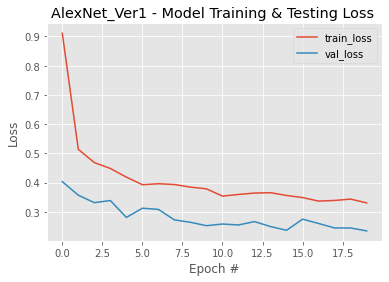

In [26]:
# plot the training and testing loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.title("AlexNet_Ver1 - Model Training & Testing Loss ")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.savefig(LOSS_PLOT_PATH)

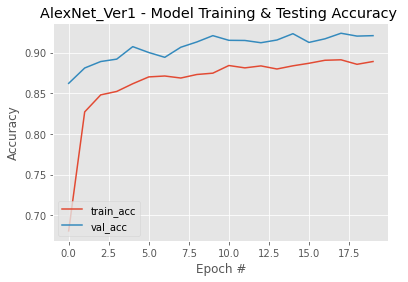

In [27]:
# plot the training and testing ccuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("AlexNet_Ver1 - Model Training & Testing Accuracy ")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.savefig(ACC_PLOT_PATH)

In [28]:
loadObject1 = torch.load(HISTORY_PATH)

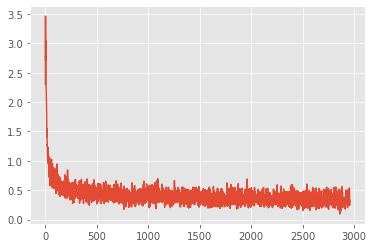

In [29]:
plt.plot(loadObject1['train_losses'])

In [30]:
print(loadObject1['avg_train_losses_per_epoch'])
print(loadObject1['avg_val_losses_per_epoch'])
print(loadObject1['avg_train_accs_per_epoch'])
print(loadObject1['avg_val_accs_per_epoch'])
print(loadObject1['training_time'])

[array(0.91099215, dtype=float32), array(0.51386917, dtype=float32), array(0.468541, dtype=float32), array(0.44840765, dtype=float32), array(0.4188525, dtype=float32), array(0.39285254, dtype=float32), array(0.3961794, dtype=float32), array(0.393485, dtype=float32), array(0.38458896, dtype=float32), array(0.37868577, dtype=float32), array(0.35387105, dtype=float32), array(0.35957482, dtype=float32), array(0.3642684, dtype=float32), array(0.36552635, dtype=float32), array(0.35610276, dtype=float32), array(0.34889534, dtype=float32), array(0.33678365, dtype=float32), array(0.3390105, dtype=float32), array(0.3436448, dtype=float32), array(0.33075362, dtype=float32)]
[array(0.40335274, dtype=float32), array(0.35701486, dtype=float32), array(0.33149955, dtype=float32), array(0.33874902, dtype=float32), array(0.28101987, dtype=float32), array(0.3125016, dtype=float32), array(0.30839854, dtype=float32), array(0.27241972, dtype=float32), array(0.2643367, dtype=float32), array(0.25269732, dtype

#5. Test Set Accuracy

In [31]:
(testDS, testLoader) = get_dataloader(TEST_DS_PATH,
                                    transforms=valTransform, 
                                    batchSize=
                                    PRED_BATCH_SIZE, 
                                    shuffle=False)

In [32]:
testSteps = len(testDS) // PRED_BATCH_SIZE
testCorrect = 0

with torch.no_grad():
      # set the model in evaluation mode
      model.eval()

      totalTestlCorrect = 0

      # loop over the test set
      for (x, y) in testLoader:
          # send the input to the device
          (x, y) = (x.to(DEVICE), y.to(DEVICE))

          # make the predictions
          pred = model(x)

          # calculate the number of correct predictions
          testCorrect += (pred.argmax(1) == y).type(torch.float).sum().item()

# calculate the test accuracy
testCorrect = testCorrect / len(testDS)

In [33]:
print('Test accuracy: ', testCorrect)

Test accuracy:  0.9151851851851852


In [34]:
def count_parameters(model):
  params = [p.numel() for p in model.parameters() if p.requires_grad]
  for item in params:
      print(f'{item:>6}')
  print(f'______\n{sum(params):>6}')

count_parameters(model)

37748736
  4096
8388608
  2048
2097152
  1024
 10240
    10
______
48251914
